## Integrate Langfuse with LlamaIndex

Integrating Langfuse with LlamaIndex to achieve observability and debugging for your LLM applications.

LlamaIndex (GitHub) is an advanced “data framework” tailored for augmenting LLMs with private data. It streamlines the integration of diverse data sources and formats (APIs, PDFs, docs, SQL, etc.) through versatile data connectors and structures data into indices and graphs for LLM compatibility. The platform offers a sophisticated retrieval/query interface for enriching LLM inputs with context-specific outputs.

### Step 1: Install Dependencies

In [ ]:
%pip install langfuse openinference-instrumentation-llama-index llama-index-llms-openai llama-index -U

### Step 2: Configure Langfuse SDK

In [6]:
import os

os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1"
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a"
os.environ["LANGFUSE_HOST"] = "http://localhost:3000"

os.environ["OPENAI_API_KEY"] = "73c80b33ad68446ea3f059efe5c1a65f.T2PZjYiHcT2JYx2a"
os.environ["OPENAI_BASE_URL"] = "https://open.bigmodel.cn/api/paas/v4"


In [7]:
from langfuse import get_client
 
langfuse = get_client()
 
# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")
 

Langfuse client is authenticated and ready!


### Step 3: Initialize LlamaIndex Instrumentation

We initialize the OpenInference LlamaIndex instrumentation. This third-party instrumentation automatically captures LlamaIndex operations and exports OpenTelemetry (OTel) spans to Langfuse.


In [8]:
from llama_index.core import Settings
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor
from langchain_openai.chat_models import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings

# Initialize LlamaIndex instrumentation
LlamaIndexInstrumentor().instrument()


# 初始化嵌入模型
embed_model = OpenAIEmbeddings(
    model="embedding-3",
)

# 初始化 LLM
llm = ChatOpenAI(
    model_name="glm-4.5-flash",
)

# 设置为全局默认
Settings.embed_model = embed_model
Settings.llm = llm

Attempting to instrument while already instrumented


### Step 4: Basic LlamaIndex Application

In [ ]:
# from llama_index.llms.openai import OpenAI
from langfuse.openai import openai

llm = openai.OpenAI()
# llm = OpenAI(model="GLM-4.5-Flash")
 
with langfuse.start_as_current_span(name="llama-index-trace"):
    response = llm.chat.completions.create(
        model="GLM-4.5-Flash",
        messages=[
            {"role": "user", "content": "What is Llama Index?"},
        ]
    ).choices[0].message.content
    # response = llm.complete("Hello, world!")
    print(response)
 
langfuse.flush()

[trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces?peek=6bef4985a292c659dc4e9f3b0430d1bd&timestamp=2025-09-08T01%3A51%3A00.673Z&observation=96216e16e7c6ae29)

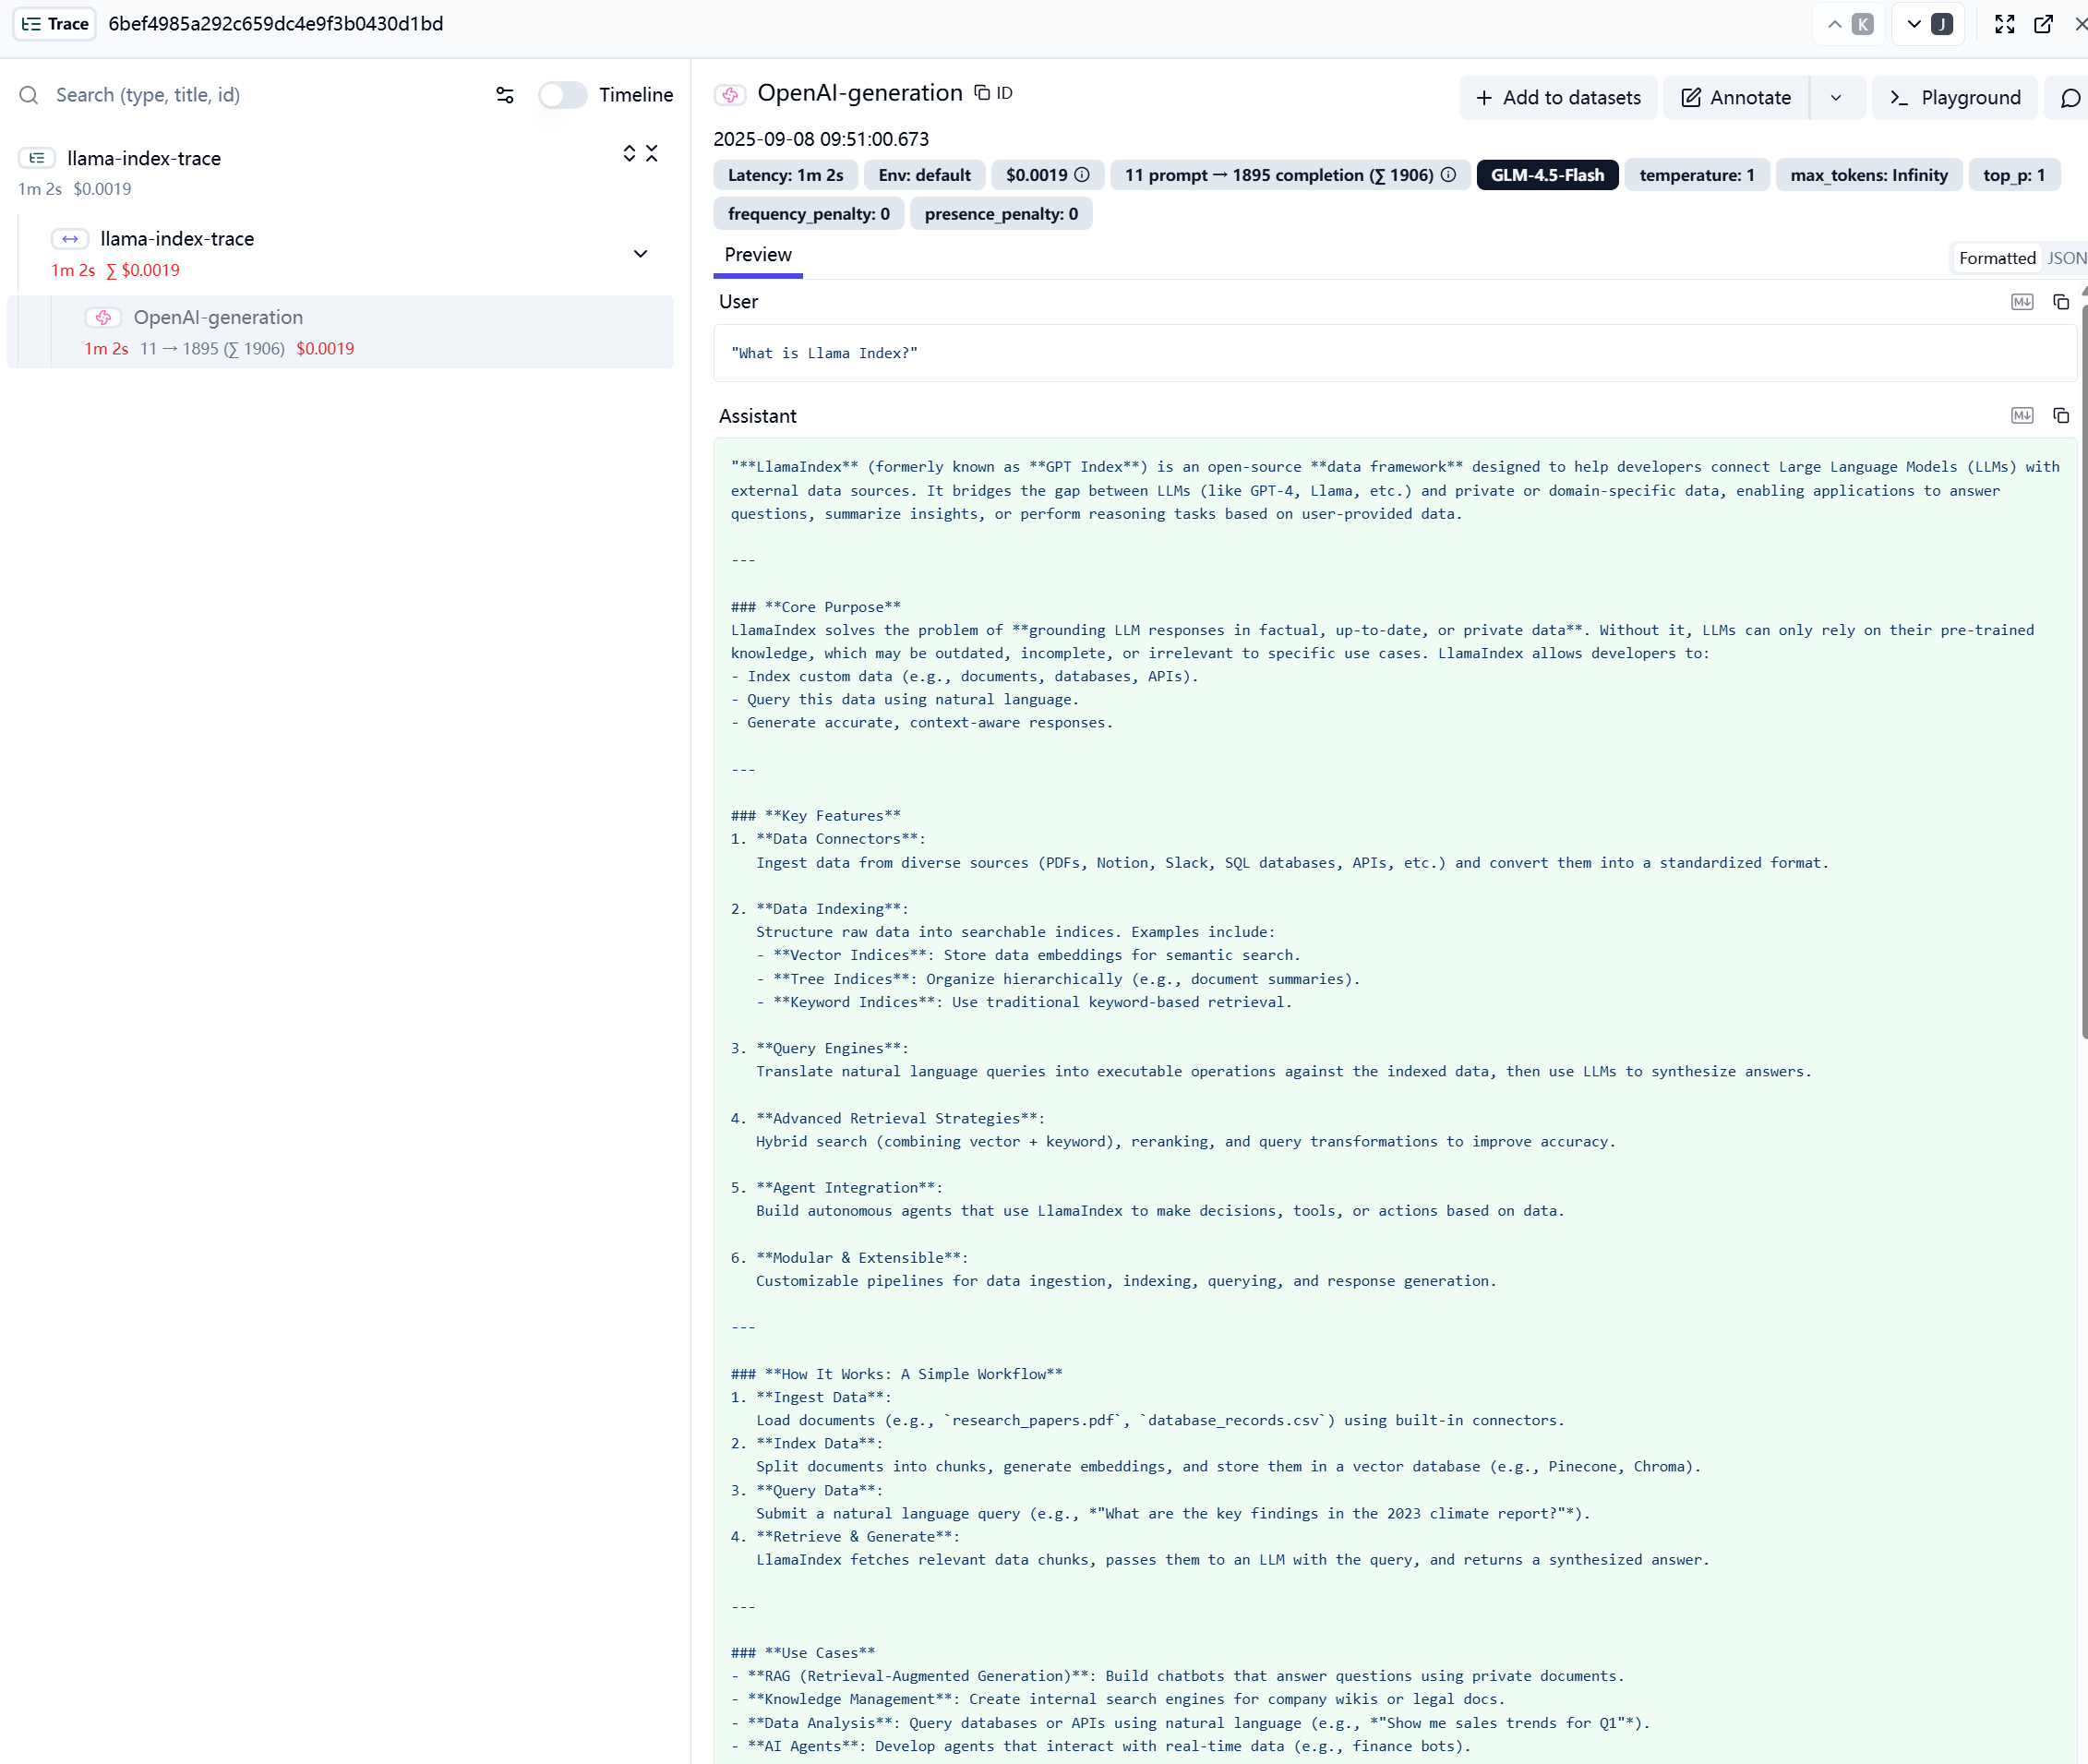

In [12]:
# Summarize cost by model
import pandas as pd

trace = langfuse.api.trace.get("6bef4985a292c659dc4e9f3b0430d1bd")
observations = trace.observations


def summarize_usage(observations):
    """Summarize usage data grouped by model."""
    usage_data = []

    for obs in observations:
        usage = obs.usage
        if usage:
            usage_data.append(
                {
                    "model": obs.model,
                    "input_tokens": usage.input,
                    "output_tokens": usage.output,
                    "total_tokens": usage.total,
                }
            )

    df = pd.DataFrame(usage_data)
    if df.empty:
        return pd.DataFrame()

    summary = df.groupby("model").sum()
    return summary


# Example usage (assuming `observations` is defined as in the provided code):
summary_df = summarize_usage(observations)
summary_df

,input_tokens,output_tokens,total_tokens
model,,,
GLM-4.5-Flash,11,1895,1906
